sensor_image -> sensor_output.fits
sensor_psf -> sensor_psf_resampled.fits
final_psf -> final_combined_psf.fits
unet_model -> unet_final.keras
Loaded sensor_image (256, 256) sensor_psf (256, 256)


C:\Users\saipr\AppData\Local\Temp\ipykernel_3660\14071404.py:83: RuntimeWarning: invalid value encountered in log1p
  plt.subplot(1,3,1); plt.title('Sensor Image (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar();
C:\Users\saipr\AppData\Local\Temp\ipykernel_3660\14071404.py:105: RuntimeWarning: invalid value encountered in log1p
  plt.subplot(1,2,2); plt.title('Original (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar()


PSF mismatch search: best sigma -> 1.5 score 0.99999905
Saved reconstruction outputs and metadata.


C:\Users\saipr\AppData\Local\Temp\ipykernel_3660\14071404.py:284: RuntimeWarning: invalid value encountered in log1p
  plt.subplot(1,4,1); plt.title('Sensor (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar()


08_reconstruction: complete — outputs saved: 08_restored_final.fits and variants.


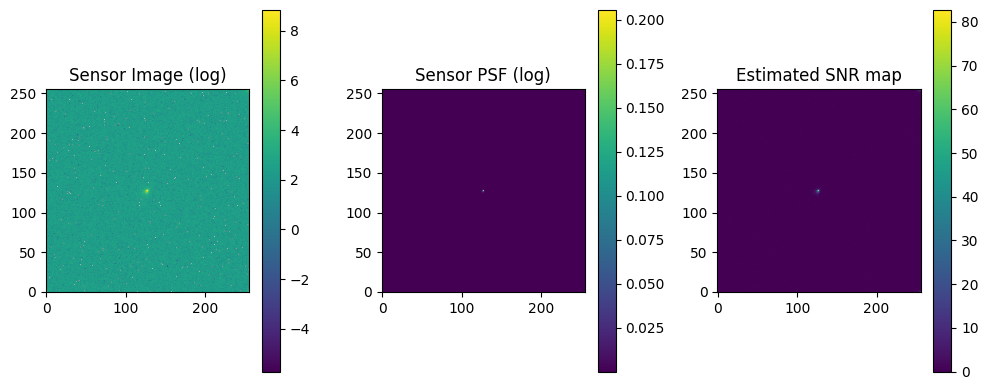

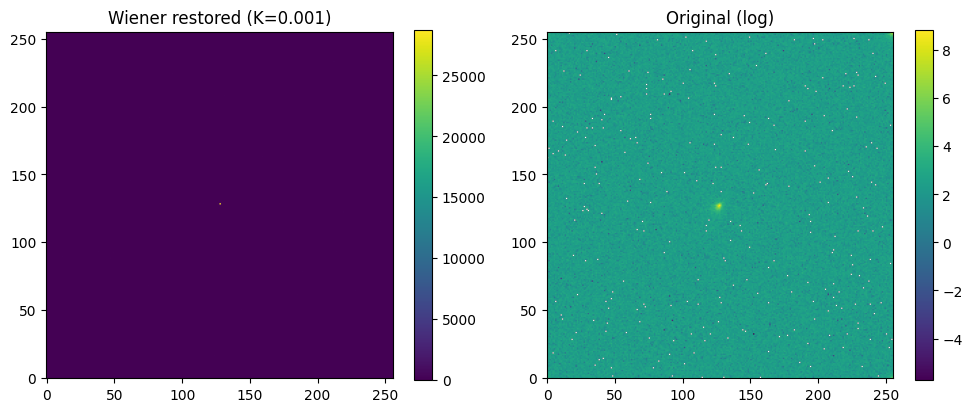

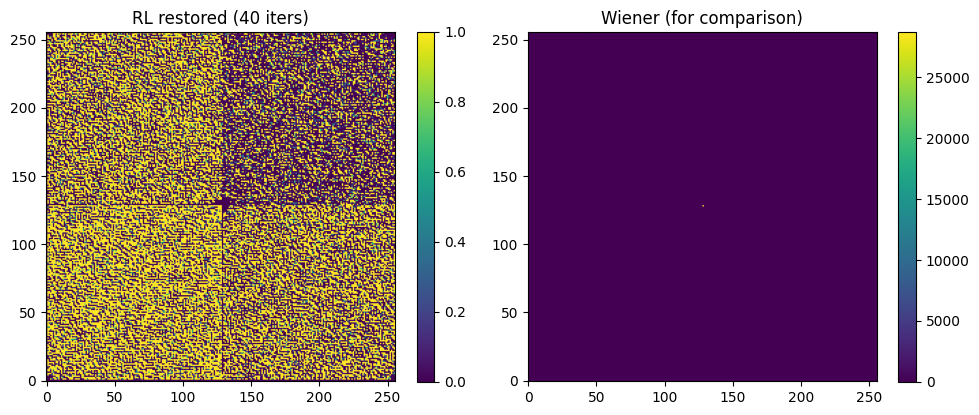

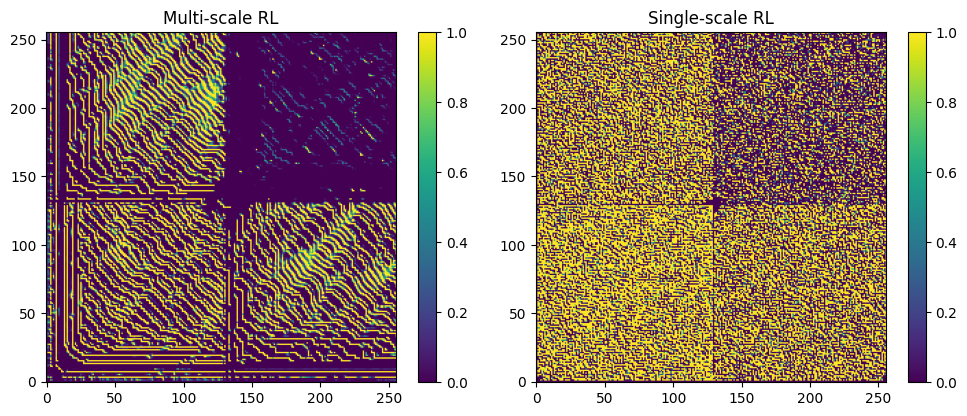

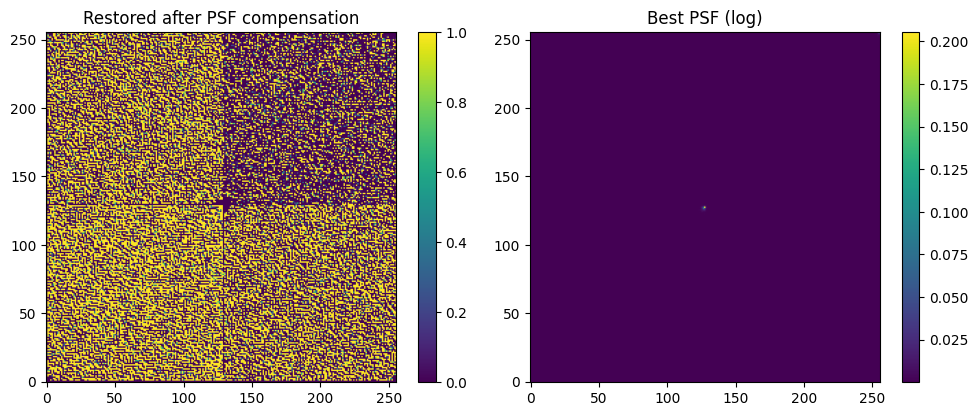

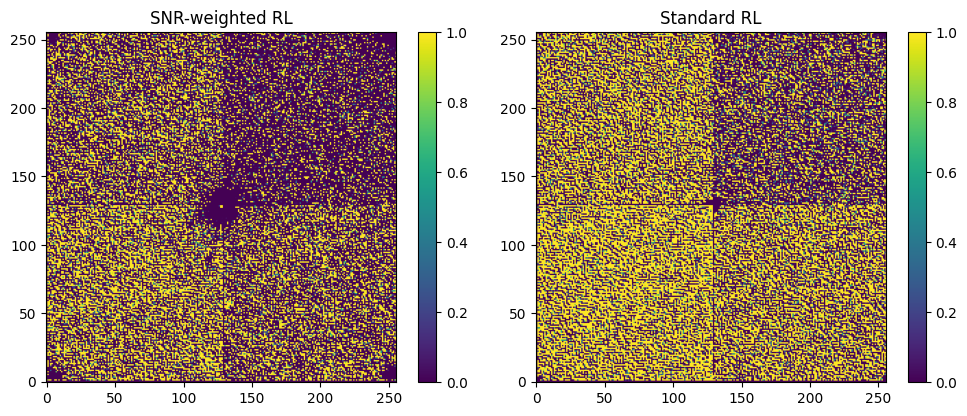

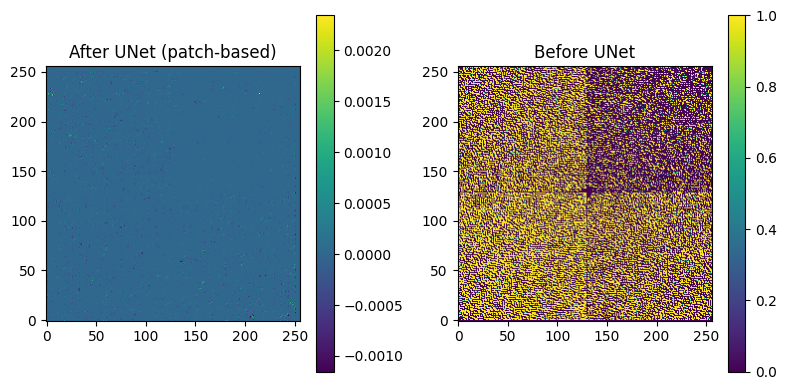

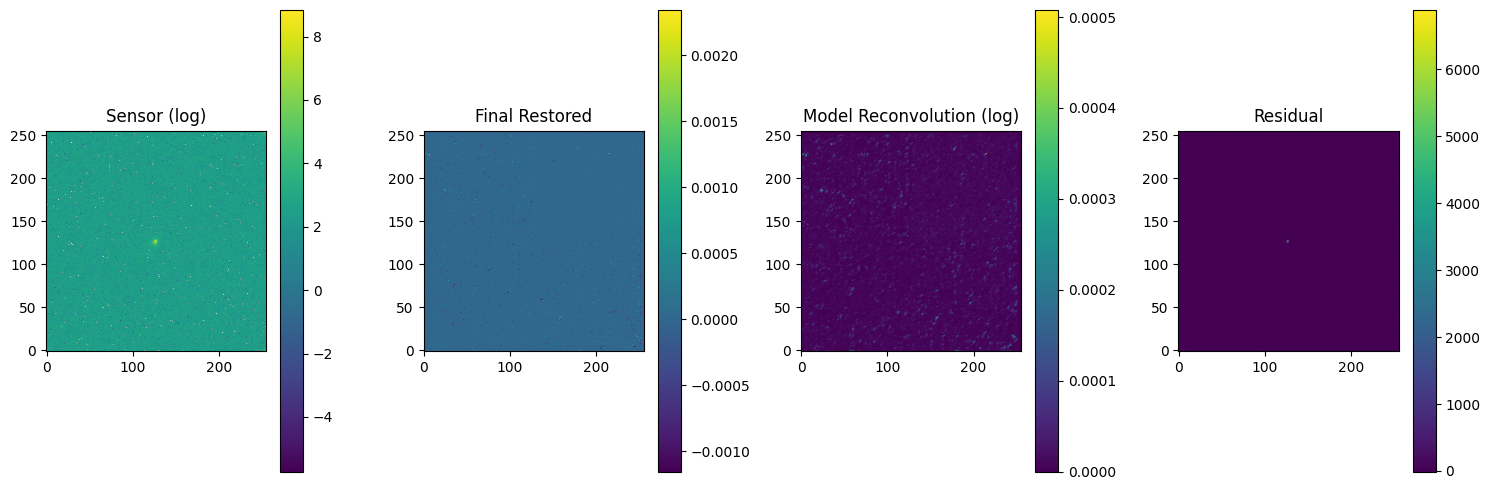

In [2]:
# 08_reconstruction.ipynb
# Advanced reconstruction pipeline (multi-resolution RL, PSF mismatch compensation,
# SNR-weighted restoration, optional AI-assisted deconvolution)
# Cells are separated with "# %%" so you can paste into a .py or run in a notebook.

# %%
# 0. Imports & configuration
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.signal import fftconvolve
from numpy.fft import fft2, ifft2, fftshift, ifftshift
from skimage.restoration import richardson_lucy
from skimage.transform import resize
import json
import os

plt.rcParams.update({'figure.max_open_warning': 0})

# %%
# 1. Load inputs (expects the outputs from previous notebooks)
# Files used: sensor_output.fits, sensor_psf_resampled.fits, final_combined_psf.fits (optional), unet_final.keras (optional)
files = {
    'sensor_image': 'sensor_output.fits',
    'sensor_psf': 'sensor_psf_resampled.fits',
    'final_psf': 'final_combined_psf.fits',
    'unet_model': 'unet_final.keras'
}

for k,f in files.items():
    print(k, '->', f)

# helper loader with graceful fallback
def load_if_exists(fname):
    if os.path.exists(fname):
        return fits.getdata(fname)
    else:
        print('MISSING:', fname)
        return None

sensor_image = load_if_exists(files['sensor_image'])
sensor_psf   = load_if_exists(files['sensor_psf'])
final_psf    = load_if_exists(files['final_psf'])

if sensor_image is None or sensor_psf is None:
    raise FileNotFoundError('Required sensor_image or sensor_psf not found. Run previous notebooks first.')

# normalize PSF (always keep a small floor)
sensor_psf = sensor_psf.astype(np.float64)
sensor_psf = sensor_psf / (sensor_psf.sum() + 1e-16)

# crop or pad PSF to image size if needed
H, W = sensor_image.shape
if sensor_psf.shape != (H, W):
    # center-resize PSF to match sensor grid
    sensor_psf = resize(sensor_psf, (H, W), mode='reflect', anti_aliasing=True)
    sensor_psf = sensor_psf / (sensor_psf.sum() + 1e-16)

print('Loaded sensor_image', sensor_image.shape, 'sensor_psf', sensor_psf.shape)

# %%
# 2. Quick diagnostics & SNR map estimate
# estimate per-pixel SNR using simple empirical model: SNR = signal / sqrt(signal + readnoise^2 + sky)
# we don't know readnoise here; choose a reasonable default or read from metadata if exists
metadata_file = '07_sensor_export_metadata.json'
read_noise = 5.0
sky_background = 15.0
assumed_gain = 1.0
if os.path.exists(metadata_file):
    try:
        m = json.load(open(metadata_file))
        read_noise = float(m.get('readout_noise', read_noise))
        sky_background = float(m.get('sky_background', sky_background))
        assumed_gain = float(m.get('gain', assumed_gain))
    except Exception:
        pass

signal = np.clip(sensor_image * assumed_gain - sky_background, 0, None)
variance = signal + read_noise**2 + 1e-6
snr_map = np.sqrt(signal**2 / variance)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); plt.title('Sensor Image (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar();
plt.subplot(1,3,2); plt.title('Sensor PSF (log)'); plt.imshow(np.log1p(sensor_psf), origin='lower'); plt.colorbar();
plt.subplot(1,3,3); plt.title('Estimated SNR map'); plt.imshow(snr_map, origin='lower'); plt.colorbar();
plt.tight_layout();

# %%
# 3. Wiener filter baseline (frequency-domain) — useful quick result
def wiener_deconv(image, psf, K=1e-3):
    # Compute FFTs
    G = fft2(image)
    H = fft2(ifftshift(psf), s=image.shape)
    H_conj = np.conj(H)
    W = H_conj / (np.abs(H)**2 + K)
    F_hat = W * G
    res = np.real(ifft2(F_hat))
    return np.clip(res, 0, None)

wiener_K = 1e-3
restored_wiener = wiener_deconv(sensor_image, sensor_psf, K=wiener_K)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('Wiener restored (K={})'.format(wiener_K)); plt.imshow(restored_wiener, origin='lower'); plt.colorbar()
plt.subplot(1,2,2); plt.title('Original (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar()
plt.tight_layout()

# %%
# 4. Richardson–Lucy (standard) — iterative and often excellent for astronomical PSFs
def rl_deconvolution(image, psf, iterations=30, clip=True):
    # scikit-image uses positional num_iter
    res = richardson_lucy(image, psf, iterations, clip=clip)
    return res


rl_iters = 40
restored_rl = rl_deconvolution(sensor_image, sensor_psf, iterations=rl_iters)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title(f'RL restored ({rl_iters} iters)'); plt.imshow(restored_rl, origin='lower'); plt.colorbar()
plt.subplot(1,2,2); plt.title('Wiener (for comparison)'); plt.imshow(restored_wiener, origin='lower'); plt.colorbar()
plt.tight_layout()

# %%
# 5. Multi-resolution RL (pyramid) — perform RL at coarse->fine scales to stabilize and speed up
from skimage.transform import pyramid_gaussian, pyramid_expand

def multiscale_rl(image, psf, levels=3, base_iters=30, scale_factor=2):
    # build gaussian pyramid for image and PSF
    imgs = [image]
    psfs = [psf]
    for lev in range(1, levels):
        imgs.append(resize(imgs[-1], (max(16, imgs[-1].shape[0]//scale_factor), max(16, imgs[-1].shape[1]//scale_factor)),
                           mode='reflect', anti_aliasing=True))
        psfs.append(resize(psfs[-1], imgs[-1].shape, mode='reflect', anti_aliasing=True))

    # start from coarsest
    est = imgs[-1].copy()
    for lev in range(levels-1, -1, -1):
        target = imgs[lev]
        psf_cur = psfs[lev]
        # RL on current level
        iters = int(base_iters / (2**lev)) + 1
        est = rl_deconvolution(est, psf_cur, iterations=iters)
        if lev > 0:
            # upsample estimate to next finer level
            est = resize(est, imgs[lev-1].shape, mode='reflect', anti_aliasing=True)
    return est

restored_mrl = multiscale_rl(sensor_image, sensor_psf, levels=3, base_iters=40)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('Multi-scale RL'); plt.imshow(restored_mrl, origin='lower'); plt.colorbar()
plt.subplot(1,2,2); plt.title('Single-scale RL'); plt.imshow(restored_rl, origin='lower'); plt.colorbar()
plt.tight_layout()

# %%
# 6. PSF mismatch compensation — allow the PSF to be slightly adjusted (small Gaussian blur / sharpening)
# We search a small family of PSFs (scale factor for gaussian smoothing) and pick the one that maximizes a simple merit: central sharpness weighted by SNR
from scipy.ndimage import gaussian_filter

def psf_family(psf, sigma_vals=[0.0, 0.5, 1.0, 1.5]):
    fam = []
    for s in sigma_vals:
        if s <= 0:
            p = psf.copy()
        else:
            p = gaussian_filter(psf, s)
        p = p / (p.sum() + 1e-16)
        fam.append((s, p))
    return fam

sigma_grid = [0.0, 0.5, 1.0, 1.5]
best_score = -np.inf
best_psf = sensor_psf
for s,p in psf_family(sensor_psf, sigma_grid):
    # quick RL few iterations and measure central peak sharpness
    est = rl_deconvolution(sensor_image, p, iterations=8)
    # score: ratio of central window peak vs surrounding median, weighted by mean SNR in window
    cx, cy = H//2, W//2
    w = 9
    window = est[cx-w:cx+w+1, cy-w:cy+w+1]
    score = window.max() / (np.median(est) + 1e-6)
    if score > best_score:
        best_score = score
        best_psf = p
print('PSF mismatch search: best sigma ->', s, 'score', best_score)

# use best_psf for a final RL
restored_psfcomp = rl_deconvolution(sensor_image, best_psf, iterations=50)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('Restored after PSF compensation'); plt.imshow(restored_psfcomp, origin='lower'); plt.colorbar()
plt.subplot(1,2,2); plt.title('Best PSF (log)'); plt.imshow(np.log1p(best_psf), origin='lower'); plt.colorbar()
plt.tight_layout()

# %%
# 7. SNR-weighted RL — in RL update formula we can weight corrections by local SNR map
# Simplified approach: multiply image by SNR^alpha to emphasis high-confidence regions before deconvolution
alpha = 0.5
image_weighted = sensor_image * (1 + (snr_map**alpha))
restored_snr_weighted = rl_deconvolution(image_weighted, sensor_psf, iterations=40)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title('SNR-weighted RL'); plt.imshow(restored_snr_weighted, origin='lower'); plt.colorbar()
plt.subplot(1,2,2); plt.title('Standard RL'); plt.imshow(restored_rl, origin='lower'); plt.colorbar()
plt.tight_layout()

# %%
# 8. Optional: AI-assisted deconvolution (UNET post-processing)
# If you have the trained UNet saved (unet_final.keras) we can run it as a final denoiser/deconvolver
use_unet = os.path.exists(files['unet_model'])
if use_unet:
    import tensorflow as tf
    unet = tf.keras.models.load_model(files['unet_model'], compile=False)
    # UNet expects 21x21 patches in your training — but we trained on patches. Here we use the UNet as patch-based denoiser.
    # We'll run sliding-window inference with overlap-add. Keep an eye on runtime.
    patch = 21
    stride = 7
    pad = patch//2
    img = restored_psfcomp.copy()
    # normalization to [0,1]
    mn, mx = img.min(), img.max()
    if mx-mn < 1e-6:
        img_norm = np.zeros_like(img)
    else:
        img_norm = (img - mn) / (mx - mn)

    out = np.zeros_like(img_norm)
    weight = np.zeros_like(img_norm)
    Hh, Ww = img_norm.shape
    for y in range(0, Hh - patch + 1, stride):
        for x in range(0, Ww - patch + 1, stride):
            p = img_norm[y:y+patch, x:x+patch]
            p_in = p[np.newaxis,...,np.newaxis].astype('float32')
            pred = unet.predict(p_in, verbose=0)[0,...,0]
            out[y:y+patch, x:x+patch] += pred
            weight[y:y+patch, x:x+patch] += 1.0
    weight[weight==0] = 1.0
    out = out / weight
    # rescale back
    denoised_unet = out * (mx-mn) + mn
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1); plt.title('After UNet (patch-based)'); plt.imshow(denoised_unet, origin='lower'); plt.colorbar()
    plt.subplot(1,2,2); plt.title('Before UNet'); plt.imshow(restored_psfcomp, origin='lower'); plt.colorbar()
    plt.tight_layout()
else:
    print('UNet model not found; skipping AI-assisted step.')

# %%
# 9. Final selection & exports
# Choose the preferred restored image (you can change variable here):
final_restored = restored_psfcomp
if use_unet:
    final_restored = denoised_unet

# Save outputs
fits.writeto('08_restored_wiener.fits', restored_wiener.astype(np.float32), overwrite=True)
fits.writeto('08_restored_rl.fits', restored_rl.astype(np.float32), overwrite=True)
fits.writeto('08_restored_mrl.fits', restored_mrl.astype(np.float32), overwrite=True)
fits.writeto('08_restored_psfcomp.fits', restored_psfcomp.astype(np.float32), overwrite=True)
if use_unet:
    fits.writeto('08_restored_unet.fits', denoised_unet.astype(np.float32), overwrite=True)
fits.writeto('08_restored_final.fits', final_restored.astype(np.float32), overwrite=True)

# Save a small JSON with choices and metadata
metadata = {
    'wiener_K': float(wiener_K),
    'rl_iters': int(rl_iters),
    'multiscale_levels': 3,
    'psf_comp_sigma_grid': sigma_grid,
    'used_unet': bool(use_unet)
}
with open('08_reconstruction_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print('Saved reconstruction outputs and metadata.')

# %%
# 10. Final visualization: compare original sensor image, best restored, and residual
res = final_restored
residual = sensor_image - fftconvolve(res, sensor_psf, mode='same')

plt.figure(figsize=(15,5))
plt.subplot(1,4,1); plt.title('Sensor (log)'); plt.imshow(np.log1p(sensor_image), origin='lower'); plt.colorbar()
plt.subplot(1,4,2); plt.title('Final Restored'); plt.imshow(res, origin='lower'); plt.colorbar()
plt.subplot(1,4,3); plt.title('Model Reconvolution (log)'); reconv = fftconvolve(res, sensor_psf, mode='same'); plt.imshow(np.log1p(np.clip(reconv,0,None)), origin='lower'); plt.colorbar()
plt.subplot(1,4,4); plt.title('Residual'); plt.imshow(residual, origin='lower'); plt.colorbar()
plt.tight_layout()

# Done. Inspect saved FITS files. Use the metadata JSON for what parameters were used.
print('08_reconstruction: complete — outputs saved: 08_restored_final.fits and variants.')
